In [1]:
import numpy as np
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt
import math
from sklearn.metrics import mean_squared_error

In [2]:
image = io.imread("/Users/piotr/Downloads/Landscape-Photography-Sophie-Turner.jpg" , as_gray=True)
image.shape

(589, 700)

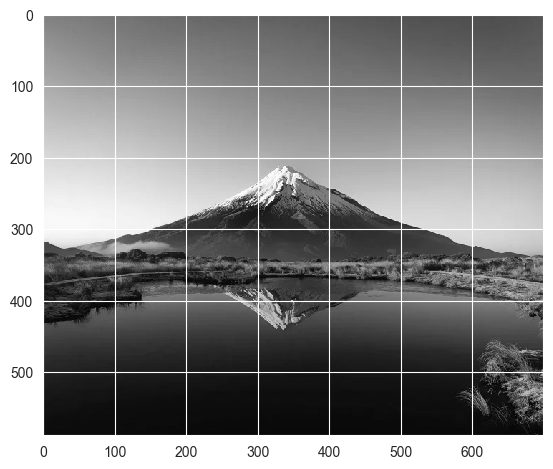

In [3]:
io.imshow(image)

In [4]:
image = resize(image, output_shape=(700, 700))
image.shape

(700, 700)

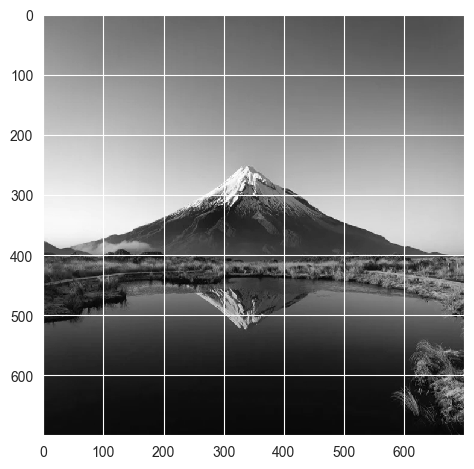

In [5]:
io.imshow(image)

# **Downsize**

In [6]:
def downsize(im, k, step: int = 1):
    result = np.zeros([math.ceil(im.shape[0] / step), math.ceil(im.shape[1] / step)])
    
    for x in range(0, im.shape[0], step):
        for y in range(0, im.shape[1], step):
            pix = (im[x : x + step, y : y + step] * k).sum()
            result[x // step, y // step] = pix
            
    return result

In [7]:
def max_pooling(im, pool_size, step=1):
    result_max = np.zeros([math.ceil(im.shape[0] / step), math.ceil(im.shape[1] / step)])
    
    for x in range(0, im.shape[0], step):
        for y in range(0, im.shape[1], step):
            patch = im[x:x+step, y:y+step]
            pooled_value = np.max(patch)
            result_max[x // step, y // step] = pooled_value
            
    return result_max

In [8]:
kernel_size = 3
kernel = np.ones([kernel_size, kernel_size]) / (kernel_size * kernel_size)
kernel

array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]])

In [9]:
downsized = downsize(image, k=kernel, step=kernel_size)
downsized.shape

(234, 234)

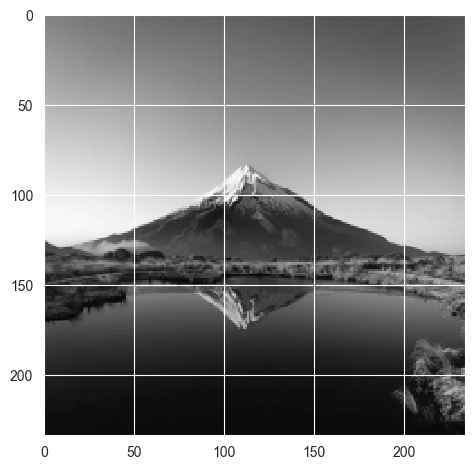

In [10]:
io.imshow(downsized)

In [11]:
max_pool = max_pooling(image, kernel, step=kernel_size)
max_pool.shape

(234, 234)

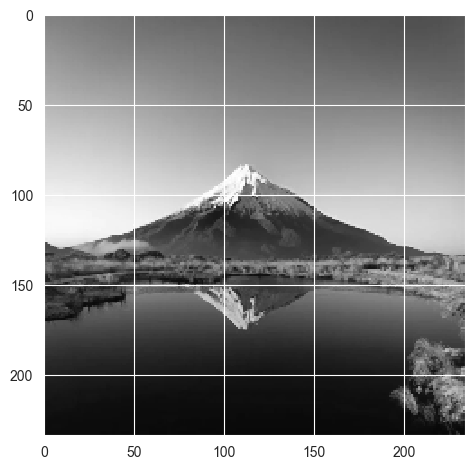

In [12]:
io.imshow(max_pool)

In [14]:
f"{(mean_squared_error(downsized, max_pool)):.4%}"

'0.1763%'

# **Upscale**

In [10]:
def conv1d_interpolate(x_measure, y_measure, x_interpolate, kernel):

    width = x_measure[1] - x_measure[0]
    kernels = [kernel(x_interpolate, x0=x0, w=width) for x0 in x_measure]

    return y_measure @ kernels

In [11]:
def linear_kernel(x, x0, w):
    x = x - x0
    x = x / w
    return ((1 - np.abs(x)) * (np.abs(x) < 1)).astype(float)

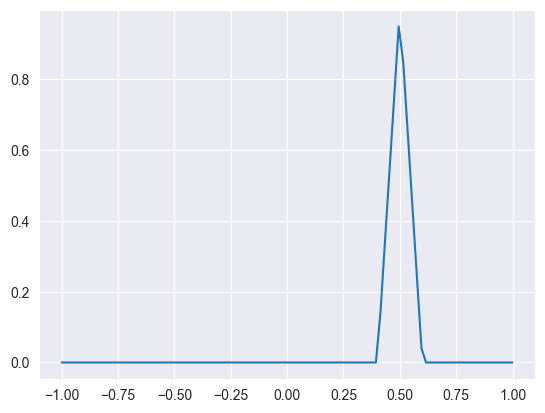

In [12]:
x = np.linspace(-1, 1, 100)
plt.plot(x, linear_kernel(x, x0=0.5, w=0.1))

In [13]:
x = np.linspace(0, 1, len(downsized[0,:]))
x_interpolate = np.linspace(0, 1, kernel_size * len(downsized[0,:]))

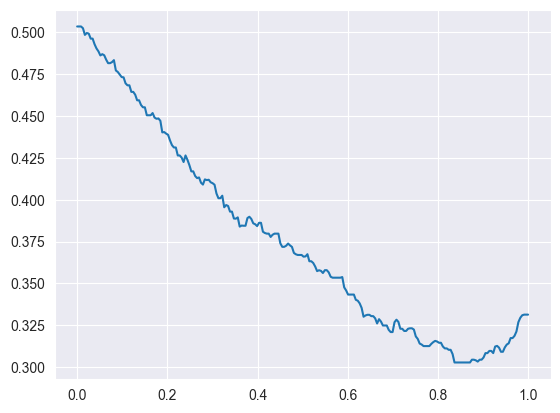

In [14]:
plt.plot(x, downsized[0, :])

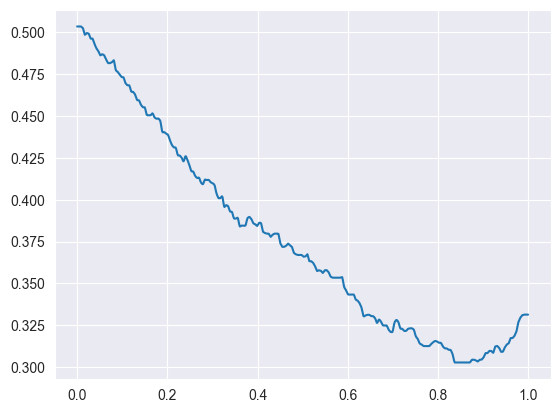

In [15]:
interpolated = conv1d_interpolate(x_measure=x, y_measure=downsized[0, :], x_interpolate=x_interpolate, kernel=linear_kernel)
plt.plot(x_interpolate, interpolated)

In [16]:
result = np.zeros([kernel_size * downsized.shape[0], downsized.shape[1]])

for row in range(downsized.shape[1]):
     result[:, row] = conv1d_interpolate(x_measure=x, y_measure=downsized[row, :], x_interpolate=x_interpolate, kernel=linear_kernel)

In [17]:
x = np.linspace(0, 1, len(downsized[0,:]))
x.shape

(234,)

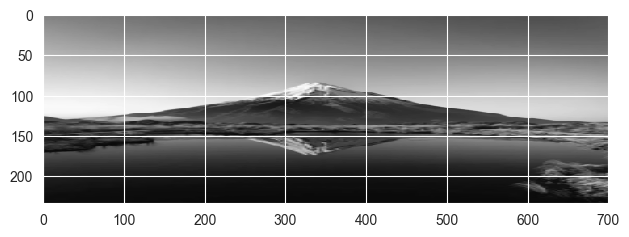

In [18]:
io.imshow(result.T)

In [19]:
result.T.shape

(234, 702)

In [20]:
final_result = np.zeros([kernel_size * downsized.shape[0], kernel_size * downsized.shape[1]])

for col in range(result.shape[0]):
    final_result[col, :] = conv1d_interpolate(x_measure=x, y_measure=result[col, :], x_interpolate=x_interpolate, kernel=linear_kernel)
    

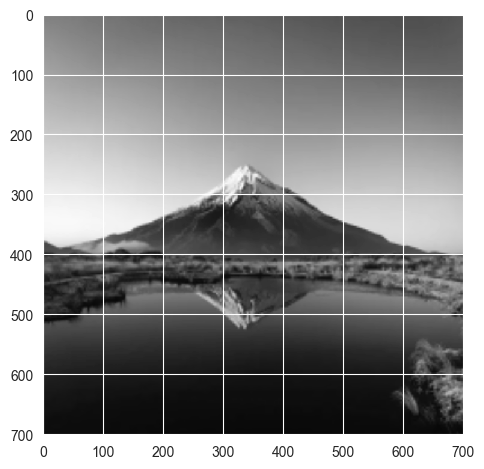

In [21]:
io.imshow(final_result.T)

In [22]:
final_result.T.shape

(702, 702)

In [23]:
if len(final_result[0]) > len(image[0]):
    final_result = resize(final_result, output_shape=(len(image[0:]), len(image[0:])))
final_result.T.shape

(700, 700)

In [24]:
f"{(mean_squared_error(image, final_result)):.4%}"

'13.4398%'

# **Upscaling/Downscaling o niecałkowitą wielokrotność**

In [40]:
numerator = 3
denominator = 4

In [41]:
x = np.linspace(0, 1, len(image[0,:]))
x_interpolate = np.linspace(0, 1, numerator * len(image[0,:]))

In [42]:
upscale_row = np.zeros([numerator * image.shape[0], image.shape[1]])

for row in range(image.shape[1]):
     upscale_row[:, row] = conv1d_interpolate(x_measure=x, y_measure=image[row, :], x_interpolate=x_interpolate, kernel=linear_kernel)

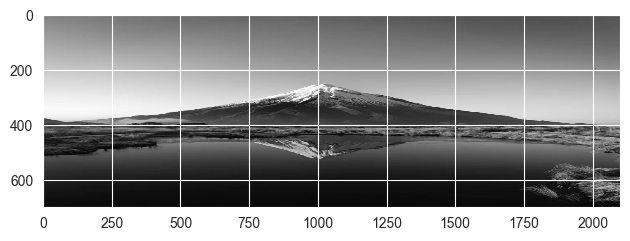

In [43]:
io.imshow(upscale_row.T)

In [44]:
upscale_row.T.shape

(700, 2100)

In [45]:
full_upscale = np.zeros([numerator * image.shape[0], numerator * image.shape[1]])

for col in range(upscale_row.shape[0]):
    full_upscale[col, :] = conv1d_interpolate(x_measure=x, y_measure=upscale_row[col, :], x_interpolate=x_interpolate, kernel=linear_kernel)

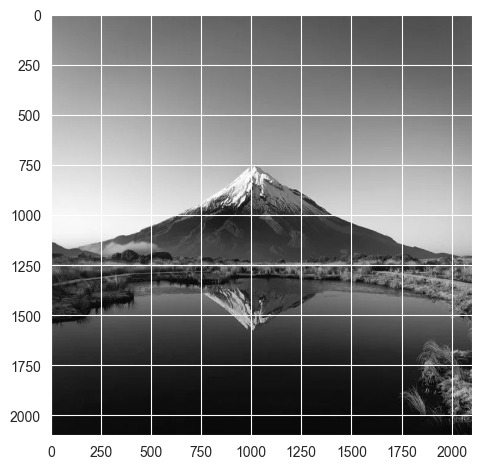

In [46]:
io.imshow(full_upscale.T)

In [47]:
full_upscale.T.shape

(2100, 2100)

In [48]:
kernel_2 = np.ones([denominator, denominator]) / (denominator * denominator)
kernel_2

array([[0.0625, 0.0625, 0.0625, 0.0625],
       [0.0625, 0.0625, 0.0625, 0.0625],
       [0.0625, 0.0625, 0.0625, 0.0625],
       [0.0625, 0.0625, 0.0625, 0.0625]])

In [49]:
fraction_interpolated = downsize(im = full_upscale.T, k=kernel_2, step=denominator)
fraction_interpolated.shape

(525, 525)

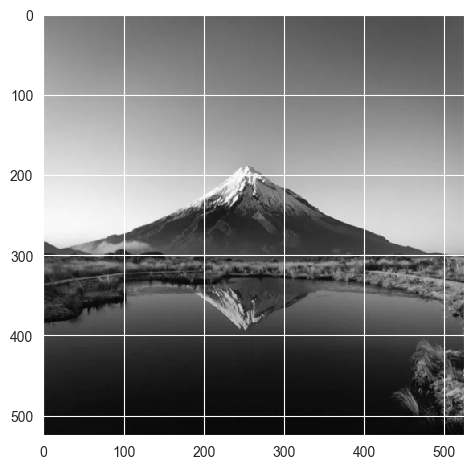

In [50]:
io.imshow(fraction_interpolated)